In [1]:
#import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics 
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
import matplotlib
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
#Import train data
data = pd.read_csv('zomato.csv')

In [3]:
data = pd.DataFrame(data)
#Glimpse of the train data
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [4]:
#!pip install numpy==1.16.5 --user

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
url                            51717 non-null object
address                        51717 non-null object
name                           51717 non-null object
online_order                   51717 non-null object
book_table                     51717 non-null object
rate                           43942 non-null object
votes                          51717 non-null int64
phone                          50509 non-null object
location                       51696 non-null object
rest_type                      51490 non-null object
dish_liked                     23639 non-null object
cuisines                       51672 non-null object
approx_cost(for two people)    51371 non-null object
reviews_list                   51717 non-null object
menu_item                      51717 non-null object
listed_in(type)                51717 non-null object
listed_in(city)                51717 non-nul

In [6]:
data.isna().sum() #Checking null values

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [7]:
pd.DataFrame(round(data.isnull().sum()/data.shape[0] * 100,3), columns = ['Missing'])

,Missing
url,0.000
address,0.000
name,0.000
online_order,0.000
book_table,0.000
rate,15.034
votes,0.000
phone,2.336
location,0.041
rest_type,0.439


In [8]:
# These columns are droped as there is no clear relationship between these two columns
data.drop(columns = ['url', 'address', 'phone', 'name', 'reviews_list'], inplace = True)

In [9]:
data.duplicated().sum()

332

In [10]:
data.drop_duplicates(inplace=True)

In [11]:
data.columns

Index(['online_order', 'book_table', 'rate', 'votes', 'location', 'rest_type',
       'dish_liked', 'cuisines', 'approx_cost(for two people)', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

### Data Cleaning

In [12]:
# Renaming and removing commas in the cost column 
data = data.rename({"approx_cost(for two people)": "cost_two"}, axis=1)
data["cost_two"] = data["cost_two"].replace(",", "", regex = True)

In [13]:
data.cost_two.unique()

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1200', '350', '250',
       '950', '1000', '1500', '1300', '199', '80', '1100', '160', '1600',
       '230', '130', '50', '190', '1700', nan, '1400', '180', '1350',
       '2200', '2000', '1800', '1900', '330', '2500', '2100', '3000',
       '2800', '3400', '40', '1250', '3500', '4000', '2400', '2600',
       '120', '1450', '469', '70', '3200', '60', '560', '240', '360',
       '6000', '1050', '2300', '4100', '5000', '3700', '1650', '2700',
       '4500', '140'], dtype=object)

In [14]:
data['cost_two'].replace(np.nan, 0, inplace=True)

In [15]:
# Converting numeric columns to their appropriate dtypes
data[["cost_two"]] = data[["cost_two"]].apply(pd.to_numeric)

In [16]:
data.rate.unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

Replacing the NEW & - value from the rate column into NaN value to convert the object data type to str.

In [17]:
data['rate'] = data.rate.replace('NEW', np.NaN)
data['rate'] = data.rate.replace('-', np.NaN)
data.rate = data.rate.astype(str)

In [18]:
data.rate = data.rate.apply(lambda x : x.replace('/5','')).astype(float)
data.head()

,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost_two,menu_item,listed_in(type),listed_in(city)
0,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,[],Buffet,Banashankari
1,Yes,No,4.1,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,[],Buffet,Banashankari
2,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,[],Buffet,Banashankari
3,No,No,3.7,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,[],Buffet,Banashankari
4,No,No,3.8,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,[],Buffet,Banashankari


In [19]:
data = data.dropna(subset=['rate'])

In [20]:
#consaverting the rate 
def rate_conversion(rate):
    newrate = 0
    if rate <= float(1):
        newrate = 1
    elif rate <= float(2):
        newrate = 2
    elif rate <= float(3):
        newrate = 3
    elif rate <= float(4):
        newrate = 4
    elif rate <= float(5):
        newrate = 5
    return newrate       

In [21]:
data.rate = data.rate.apply(lambda x: rate_conversion(x))
data.head()

,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost_two,menu_item,listed_in(type),listed_in(city)
0,Yes,Yes,5,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,[],Buffet,Banashankari
1,Yes,No,5,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,[],Buffet,Banashankari
2,Yes,No,4,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,[],Buffet,Banashankari
3,No,No,4,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,[],Buffet,Banashankari
4,No,No,4,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,[],Buffet,Banashankari


In [22]:
data.rate.unique()

array([5, 4, 3, 2], dtype=int64)

In [23]:
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0 

for i in data["rate"]:
    if i == 1:
        count1 += 1
    elif i == 2:
        count2 += 1
    elif i == 3:
        count3 += 1
    elif i == 4:
        count4 += 1
    elif i == 5:
        count5 += 1

print(str(count1) +" "+ str(count2) +" "+ str(count3) +" "+ str(count4) +" "+ str(count5))        

0 16 3261 29134 9192


### Data Analysis & Visualization


Checking the count of each rating category present

C:\Users\Vithyashagar\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='rate', ylabel='Density'>

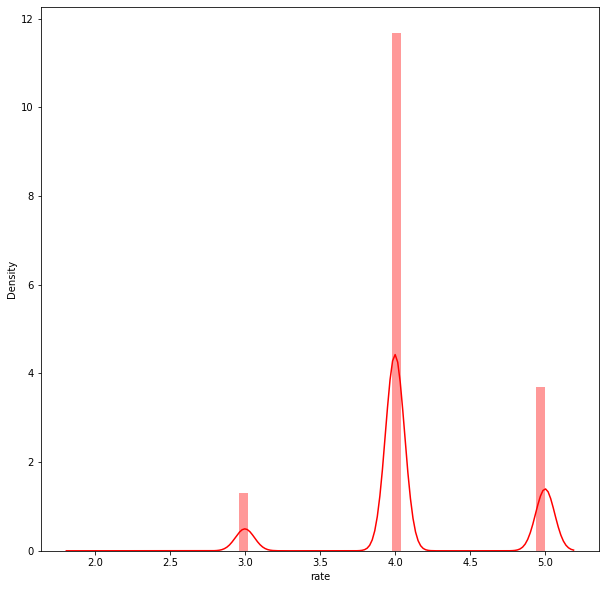

In [24]:
#Rate plot before Discretizing 
plt.figure(figsize = (10, 10))
sns.distplot(data['rate'], color = 'red')

PLotting a joint plot for rate vs votes

It can be observed that if the restaurant which dont have online order facility are more like to lose the rating as compared to the restuarants which have online order facility

In [25]:
data.head(3)

,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost_two,menu_item,listed_in(type),listed_in(city)
0,Yes,Yes,5,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,[],Buffet,Banashankari
1,Yes,No,5,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,[],Buffet,Banashankari
2,Yes,No,4,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,[],Buffet,Banashankari


### Data pre-processing

In [26]:
data = data.dropna()

In [27]:
#Dropping unrelated columns for rating
data = data.drop(['dish_liked', 'menu_item'],axis = 1)
data.head()

,online_order,book_table,rate,votes,location,rest_type,cuisines,cost_two,listed_in(type),listed_in(city)
0,Yes,Yes,5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Yes,No,5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,Banashankari
2,Yes,No,4,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,No,No,4,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet,Banashankari
4,No,No,4,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet,Banashankari


In [28]:
data = data.rename(columns = {"listed_in(type)":"type", "listed_in(city)":"city"})

In [29]:
data.cuisines

0                     North Indian, Mughlai, Chinese
1                        Chinese, North Indian, Thai
2                             Cafe, Mexican, Italian
3                         South Indian, North Indian
4                           North Indian, Rajasthani
                            ...                     
51705       North Indian, Continental, Mediterranean
51707                                    Finger Food
51708             Chinese, Continental, North Indian
51711    Andhra, South Indian, Chinese, North Indian
51715                                    Finger Food
Name: cuisines, Length: 23358, dtype: object

In [30]:
data.cuisines = data.cuisines.apply(lambda x: x.split(', '))

In [31]:
cuisines_dict = {}

for _, types in data.cuisines.iteritems():
    for t in types:
        if(t not in cuisines_dict):
            cuisines_dict[t] = 1
        elif(t in cuisines_dict):
            cuisines_dict[t] += 1

In [32]:
from collections import Counter

In [33]:
top10 = Counter(cuisines_dict).most_common(10)
top_cusines = []

for i in top10:
    top_cusines.append(i[0])

top_cusines

['North Indian',
 'Chinese',
 'Continental',
 'Cafe',
 'Fast Food',
 'South Indian',
 'Italian',
 'Desserts',
 'Biryani',
 'Beverages']

In [34]:
def remove_unwanted_cusines(types, usines):
    new_cusines = []
    
    for t in types:
        if t in top_cusines:
            new_cusines.append(t)
    
    new_cusines.sort()
    sent = ",".join(new_cusines)
    
    return sent

In [35]:
#print(data.cuisines[1])
#x = remove_unwanted_cusines(data.cuisines[1], top_cusines)
#print(x)
data.cuisines = data.cuisines.apply(lambda x: remove_unwanted_cusines(x, top_cusines))
data.head()

,online_order,book_table,rate,votes,location,rest_type,cuisines,cost_two,type,city
0,Yes,Yes,5,775,Banashankari,Casual Dining,"Chinese,North Indian",800,Buffet,Banashankari
1,Yes,No,5,787,Banashankari,Casual Dining,"Chinese,North Indian",800,Buffet,Banashankari
2,Yes,No,4,918,Banashankari,"Cafe, Casual Dining","Cafe,Italian",800,Buffet,Banashankari
3,No,No,4,88,Banashankari,Quick Bites,"North Indian,South Indian",300,Buffet,Banashankari
4,No,No,4,166,Basavanagudi,Casual Dining,North Indian,600,Buffet,Banashankari


In [36]:
cuisines_dummy = data.cuisines.str.get_dummies(sep=',')
data.drop(columns='cuisines', inplace = True)
data = pd.concat([data,cuisines_dummy],axis=1)

In [37]:
#restType_dummy = pd.DataFrame(pd.get_dummies(data['rest_type'], drop_first = True))

restType_dummy = data.rest_type.str.get_dummies(sep=', ')
data.drop(columns='rest_type', inplace = True)
data = pd.concat([data,restType_dummy],axis=1)

In [38]:
data.head()

,online_order,book_table,rate,votes,location,cost_two,type,city,Beverages,Biryani,...,Food Truck,Irani Cafee,Kiosk,Lounge,Mess,Microbrewery,Pub,Quick Bites,Sweet Shop,Takeaway
0,Yes,Yes,5,775,Banashankari,800,Buffet,Banashankari,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Yes,No,5,787,Banashankari,800,Buffet,Banashankari,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Yes,No,4,918,Banashankari,800,Buffet,Banashankari,0,0,...,0,0,0,0,0,0,0,0,0,0
3,No,No,4,88,Banashankari,300,Buffet,Banashankari,0,0,...,0,0,0,0,0,0,0,1,0,0
4,No,No,4,166,Basavanagudi,600,Buffet,Banashankari,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data.location = le.fit_transform(data.location)

data.online_order = le.fit_transform(data.online_order)
data.book_table = le.fit_transform(data.book_table)
data.type = le.fit_transform(data.type)
data.city = le.fit_transform(data.city)

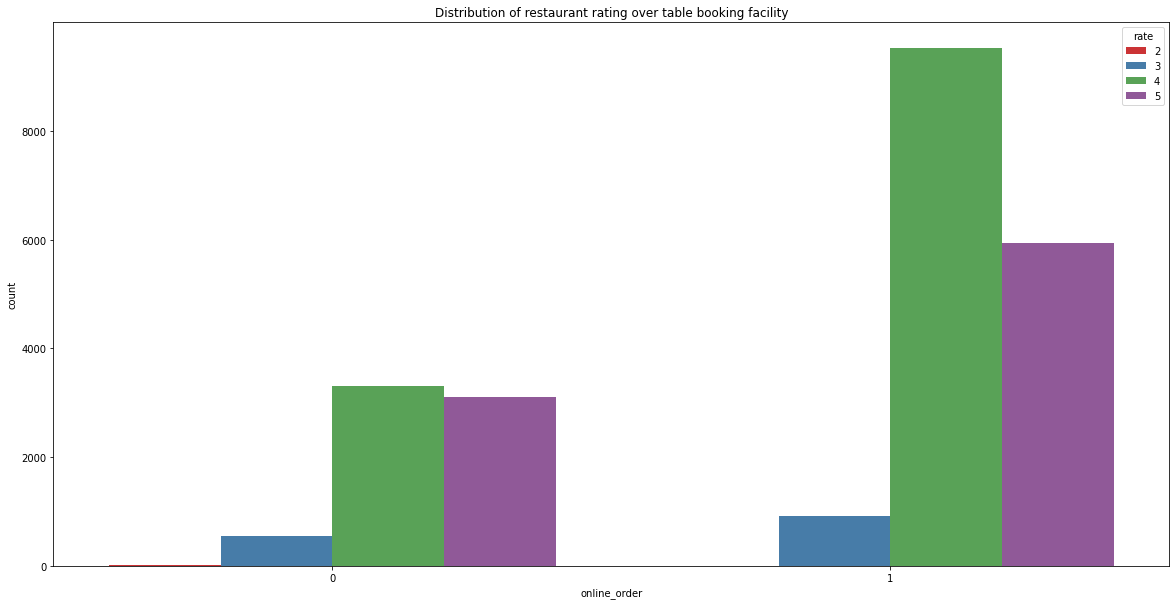

In [41]:
plt.figure(figsize=(20,10))
sns.countplot(x = data['online_order'], hue = data['rate'], palette= 'Set1')
plt.title("Distribution of restaurant rating over table booking facility")
plt.show()

# check how to rating affects if the restaurant has table booking or not. 

<Figure size 1008x720 with 0 Axes>

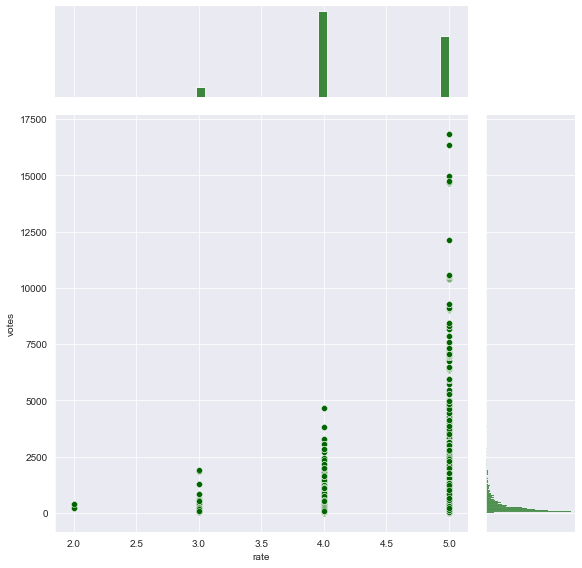

In [42]:
plt.figure(figsize=(14,10))
sns.set_style("darkgrid")
sns.jointplot(x = 'rate', y = 'votes', data=data, color = 'darkgreen',height = 8, ratio = 4)
#Checking whether the online order facility impacts the rating of the restaurants

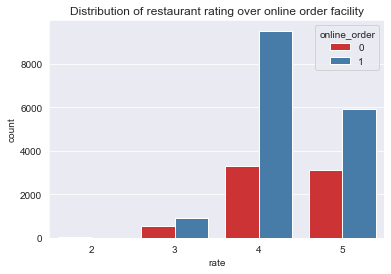

In [43]:

sns.countplot(x = data['rate'], hue = data['online_order'], palette= 'Set1')
plt.title("Distribution of restaurant rating over online order facility")
plt.show()

In [44]:
data.drop(columns = ["city"], inplace=True)

### Model Building

In [45]:
data = data.astype("int64")

In [46]:
# Splitting the features into independent and dependent variables

x = data.drop(['rate'], axis = 1)
y = data['rate']

In [47]:
#Spliting data into test and train

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20)

Decision Tree Regressor

In [57]:
from sklearn.tree import DecisionTreeRegressor
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report

DTree=DecisionTreeRegressor(min_samples_leaf=.0001)
DTree.fit(x_train,y_train)
y_predict=DTree.predict(x_test)

y_predict = y_predict.round(0)
y_predict.astype("int64")

print(classification_report(y_predict,y_test))

              precision    recall  f1-score   support

         2.0       0.50      1.00      0.67         2
         3.0       0.74      0.80      0.77       274
         4.0       0.96      0.93      0.94      2630
         5.0       0.94      0.97      0.95      1766

    accuracy                           0.94      4672
   macro avg       0.79      0.92      0.83      4672
weighted avg       0.94      0.94      0.94      4672



In [58]:
confusion = confusion_matrix(y_predict,y_test)
print(confusion)

[[   2    0    0    0]
 [   0  218   55    1]
 [   2   74 2438  116]
 [   0    1   47 1718]]


In [59]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(confusion,
                     index = ['1','2','3','4'], 
                     columns = ['1','2','3','4'])

Random Forest Regressor

In [61]:
#Preparing Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
RForest=RandomForestRegressor(n_estimators=500,random_state=329,min_samples_leaf=.0001)
RForest.fit(x_train,y_train)
y_predict=RForest.predict(x_test)

y_predict = y_predict.round(0)
y_predict.astype("int64")

print(classification_report(y_predict,y_test))

              precision    recall  f1-score   support

         2.0       0.50      1.00      0.67         2
         3.0       0.76      0.99      0.86       225
         4.0       0.99      0.94      0.96      2678
         5.0       0.95      0.99      0.97      1767

    accuracy                           0.96      4672
   macro avg       0.80      0.98      0.86      4672
weighted avg       0.96      0.96      0.96      4672



In [62]:
confusion_matrix(y_predict,y_test)

array([[   2,    0,    0,    0],
       [   0,  222,    3,    0],
       [   2,   71, 2514,   91],
       [   0,    0,   23, 1744]], dtype=int64)

Extra Trees Classifier

In [63]:
#Fit Extra Trees Classifier with hyper parameters
etc = ExtraTreesClassifier(random_state=2, n_estimators=1000 )
etc.fit(x_train, y_train)
  
# make prediction using our test data and model
y_pred_etc = etc.predict(x_test)
#y_prob_etc = etc.predict_proba(X_test)[:, 1]
 
# Comparing our prediciton to response values
y_predict = y_predict.round(0)
y_predict.astype("int64")

print(classification_report(y_predict,y_test))

              precision    recall  f1-score   support

         2.0       0.50      1.00      0.67         2
         3.0       0.76      0.99      0.86       225
         4.0       0.99      0.94      0.96      2678
         5.0       0.95      0.99      0.97      1767

    accuracy                           0.96      4672
   macro avg       0.80      0.98      0.86      4672
weighted avg       0.96      0.96      0.96      4672



In [64]:
confusion_matrix(y_predict,y_test)

array([[   2,    0,    0,    0],
       [   0,  222,    3,    0],
       [   2,   71, 2514,   91],
       [   0,    0,   23, 1744]], dtype=int64)

Extra Tree Regression

In [65]:
#Preparing Extra Tree Regression
from sklearn.ensemble import  ExtraTreesRegressor
ETree=ExtraTreesRegressor(n_estimators = 100)
ETree.fit(x_train,y_train)
y_predict=ETree.predict(x_test)

y_predict = y_predict.round(0)
y_predict.astype("int64")

print(classification_report(y_predict,y_test))

              precision    recall  f1-score   support

         2.0       0.50      1.00      0.67         2
         3.0       0.85      0.96      0.90       258
         4.0       0.99      0.96      0.98      2599
         5.0       0.97      0.99      0.98      1813

    accuracy                           0.97      4672
   macro avg       0.83      0.98      0.88      4672
weighted avg       0.97      0.97      0.97      4672



In [66]:
confusion_matrix(y_predict,y_test)

array([[   2,    0,    0,    0],
       [   0,  248,   10,    0],
       [   2,   44, 2506,   47],
       [   0,    1,   24, 1788]], dtype=int64)

Gradient Boosting Regressor

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)

y_predict=gbr.predict(x_test)

y_predict = y_predict.round(0)
y_predict.astype("int64")

print(classification_report(y_predict,y_test))

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         1
         4.0       0.90      0.72      0.80      3163
         5.0       0.69      0.83      0.75      1508

    accuracy                           0.76      4672
   macro avg       0.40      0.39      0.39      4672
weighted avg       0.83      0.76      0.79      4672



C:\Users\Vithyashagar\anaconda3\envs\venev\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\Vithyashagar\anaconda3\envs\venev\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\Vithyashagar\anaconda3\envs\venev\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



XGBRegressor